<a href="https://colab.research.google.com/github/StanleyLiangYork/Advance_NN_techniques/blob/main/Grad_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
import cv2

In [3]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

Grad-CAM (Gradient-weighted Class Activation Mapping) is a technique used in deep learning computer vision models to visualize the regions of an input image that are important for making a specific prediction. It was introduced by Selvaraju et al. in 2017 as a way to provide visual explanations for the predictions made by convolutional neural networks (CNNs) and other similar models.<p>
The output of Grad-CAM is an activation map which localizes the detected objected to a region in the image. It is of width $u$ and height $v$, for the class $c$.
\begin{align}
L_{Grad-CAM}^c \in \mathbb{R}^{u \times v} 
\end{align}

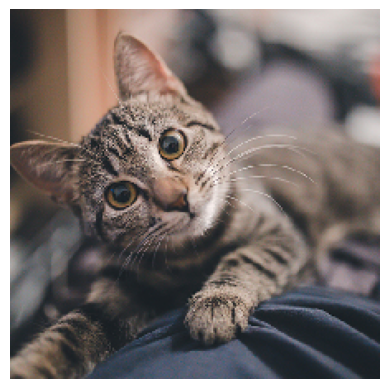

In [4]:
image = np.array(load_img("cat.jpg", target_size=(224, 224, 3)))
plt.axis('off')
plt.imshow(image)

Define a Grad-CAM class

In [15]:
class GradCAM_Maker:
  def __init__(self, model, layer_name: str):
    self.model = model
    self.layer_name = layer_name

  def build_model(self):
    activation_map_layer = model.get_layer(self.layer_name)
    activation_model = tf.keras.Model(model.inputs, activation_map_layer.output)
    classifier_input = tf.keras.Input(shape=activation_map_layer.output.shape[1:]) # remove the batch dimension
    x = classifier_input
    x = model.layers[-2](x)
    x = model.layers[-1](x)
    classifier_model = tf.keras.Model(classifier_input, x)
    self.activation_model = activation_model
    self.classifier_model = classifier_model

  def get_gradmap(self, image):
    with tf.GradientTape() as tape:
      inputs = image[np.newaxis, ...]
      feature_map = self.activation_model(inputs)
      tape.watch(feature_map)
      preds = self.classifier_model(feature_map)
      top_pred_index = tf.argmax(preds[0]) # remove the batch dimension
      top_class_channel = preds[:, top_pred_index]
    grads = tape.gradient(top_class_channel, feature_map)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    activation_map = feature_map.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
      activation_map[:, :, i] *= pooled_grads[i]
    gradcam = np.mean(activation_map, axis=-1)
    # like ReLU, rescale the grad pixel values to (0, normalized value)
    gradcam = np.clip(gradcam, 0, np.max(gradcam)) / np.max(gradcam)
    gradcam = cv2.resize(gradcam, (224, 224))
    
    return gradcam



In [6]:
model = ResNet50()

102967424/102967424 [==============================] - 1s 0us/step


In [17]:
gradCAM = GradCAM_Maker(model, 'conv5_block3_out')

In [18]:
gradCAM.build_model()

In [19]:
image = np.array(load_img("cat.jpg", target_size=(224, 224, 3)))

In [20]:
image = cv2.imread("cat.jpg")

In [21]:
image = cv2.resize(image, (224,224))

In [22]:
grad_map = gradCAM.get_gradmap(image)

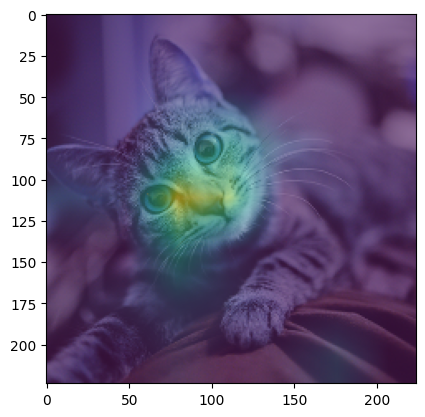

In [23]:
plt.imshow(image)
plt.imshow(grad_map, alpha=0.5)


In [24]:
for layer in model.layers:
  print(layer.name)

input_1
conv1_pad
conv1_conv
conv1_bn
conv1_relu
pool1_pad
pool1_pool
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_2_bn
conv2_block1_2_relu
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block1_0_bn
conv2_block1_3_bn
conv2_block1_add
conv2_block1_out
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_2_bn
conv2_block2_2_relu
conv2_block2_3_conv
conv2_block2_3_bn
conv2_block2_add
conv2_block2_out
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_2_bn
conv2_block3_2_relu
conv2_block3_3_conv
conv2_block3_3_bn
conv2_block3_add
conv2_block3_out
conv3_block1_1_conv
conv3_block1_1_bn
conv3_block1_1_relu
conv3_block1_2_conv
conv3_block1_2_bn
conv3_block1_2_relu
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block1_0_bn
conv3_block1_3_bn
conv3_block1_add
conv3_block1_out
conv3_block2_1_conv
conv3_block2_1_bn
conv3_block2_1_relu
conv3_block2_2_conv
conv3_block2_2_bn
conv3_

pick the last block output - conv5_block3_out

In [155]:
last_conv_layer = model.get_layer("conv5_block3_out")

In [156]:
last_conv_layer.output.shape

TensorShape([None, 7, 7, 2048])

A new model with the activation map output

In [157]:
last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)

In [158]:
# get the shape of the last activation map
shape=last_conv_layer.output.shape[1:] # remove the batch dimension

In [159]:
shape

TensorShape([7, 7, 2048])

In [160]:
classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in ["avg_pool", "predictions"]:
    x = model.get_layer(layer_name)(x) 

# this new classifier takes the lost activation feature map as input and uses the last two layers from the ResNet for prediction
classifier_model = tf.keras.Model(classifier_input, x)

Trace the gradients

In [161]:
with tf.GradientTape() as tape:
    inputs = image[np.newaxis, ...]
    last_conv_layer_output = last_conv_layer_model(inputs)
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

In [162]:
last_conv_layer_output.shape

TensorShape([1, 7, 7, 2048])

The partial derivative / gradient of the model output with respect to a designated feature activation map activations of a specified convolution layer (the last convolution layer in this case) is defined as:
\begin{align}
        \frac{\partial y^c}{\partial A_{ij}^k}
    \end{align}

In [163]:
# get the gradient with respect of the top class channel
grads = tape.gradient(top_class_channel, last_conv_layer_output)
grads.shape

TensorShape([1, 7, 7, 2048])

The above gradients have a shape of $(u,v,Z)$, where $(u,v)$ is the shape of the 2D convolution filter (i.e. width=$u$ and height=$v$), and $Z$ is the number of filters or total channels. The next step is to reduce the averages of each filter to a single value, which is equivalent to the global average pooling 2D layer.
\begin{align}
        \mathbf{\alpha_c^k} = \frac{1}{Z} \sum_{i} \sum_{j} \frac{\partial y^c}{\partial A_{ij}^k} 
    \end{align}
    Each gradient value represents the connection from one pixel in the 2D image array to the final neuron output representing the target class.<p>
    Then we multiply the gradients (corresponding to the importance of the given feature map / filter) with the actual feature map (filter) it represents.

In [164]:
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
pooled_grads.shape

TensorShape([2048])

In [165]:
last_conv_layer_output = last_conv_layer_output.numpy()[0] # remove the batch dimension
# pooled_grads = pooled_grads.numpy()
# for i in range(pooled_grads.shape[-1]):
#     last_conv_layer_output[:, :, i] *= pooled_grads[i]

In [166]:
last_conv_layer_output.shape

(7, 7, 2048)

In [167]:
pooled_grads.shape

TensorShape([2048])

In [168]:
grad_map = last_conv_layer_output @ pooled_grads[..., tf.newaxis]

In [169]:
grad_map.shape

TensorShape([7, 7, 1])

In [63]:
# Average over all the filters to get a single 2D array
gradcam = np.mean(last_conv_layer_output, axis=-1)
# Clip the values (equivalent to applying ReLU)
# and then normalise the values
gradcam = np.clip(gradcam, 0, np.max(gradcam)) / np.max(gradcam)
gradcam = cv2.resize(gradcam, (224, 224))

(-0.5, 223.5, 223.5, -0.5)

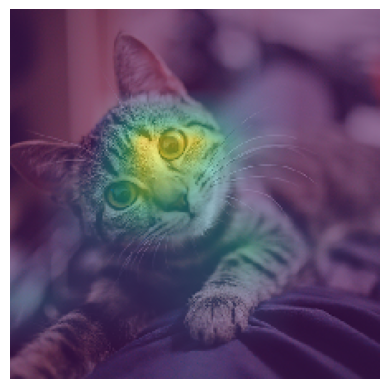

In [65]:
plt.imshow(image)
plt.imshow(gradcam, alpha=0.5)
plt.axis('off')

# Counterfactual explanation
By negating or denying the value of $\frac{\partial y^c}{\partial A_{ij}^k}$, we can produce a map of regions that would lower the network's confidence in its prediction. This is useful when two competing objects are present in the image. We can produce a "counterfactual" image with these regions masked out, which should give a higher confidence in the original prediction.

In [67]:
multiobject_image = np.array(load_img("cat_and_dog.jpg", target_size=(224, 224, 3)))

In [68]:
with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(multiobject_image[np.newaxis, ...])
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

In [69]:
grads = tape.gradient(top_class_channel, last_conv_layer_output)

get the negative of the gradients. This counterfactual gradients targets the region that do not contribute towards strengthen the network's predictions.

In [70]:
pooled_grads = tf.reduce_mean(-1 * grads, axis=(0, 1, 2))

In [73]:
last_conv_layer_output = last_conv_layer_output.numpy()[0] # remove the batch dimension
pooled_grads = pooled_grads.numpy()
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]

In [74]:
last_conv_layer_output.shape

(7, 7, 2048)

In [86]:
# Average over all the filters to get a single 2D array
ctfcl_gradcam = np.mean(last_conv_layer_output, axis=-1)
# Normalise the values
ctfcl_gradcam = np.clip(ctfcl_gradcam, 0, np.max(ctfcl_gradcam)) / np.max(ctfcl_gradcam)
ctfcl_gradcam = cv2.resize(ctfcl_gradcam, (224, 224))

(-0.5, 223.5, 223.5, -0.5)

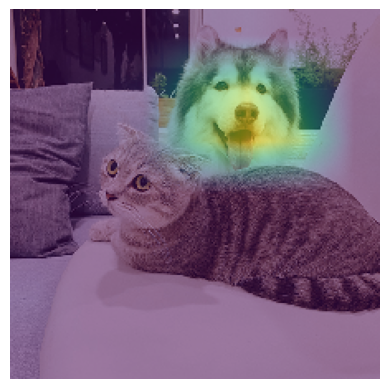

In [87]:
plt.imshow(multiobject_image)
plt.imshow(ctfcl_gradcam, alpha=0.5)
plt.axis('off')

In [90]:
mask = cv2.resize(ctfcl_gradcam, (224, 224))
mask[mask > 0.1] = 255
mask[mask != 255] = 0
mask = mask.astype(bool)

In [91]:
ctfctl_image = multiobject_image.copy()
ctfctl_image[mask] = (0, 0, 0)

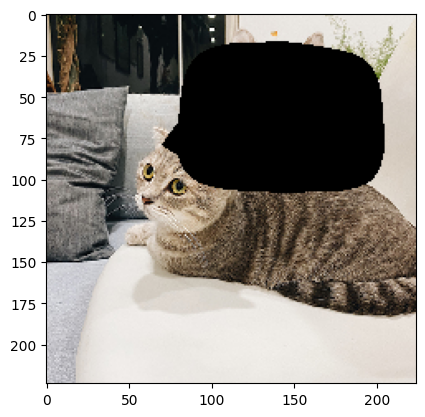

In [92]:
plt.imshow(ctfctl_image)

In [101]:
print('======before remove the confused pixels======')
predicts = decode_predictions(model.predict(image[np.newaxis, ...]))
print('Top 5 pridictions:')
for i in range(5):
  print(predicts[0][i])
print('======after remove the confused pixels=======')
predicts = decode_predictions(model.predict(ctfctl_image[np.newaxis, ...]))
print('Top 5 pridictions:')
for i in range(5):
  print(predicts[0][i])

======before remove the confused pixels======
1/1 [==============================] - 0s 24ms/step
Top 5 pridictions:
('n02127052', 'lynx', 0.32931536)
('n02123045', 'tabby', 0.1809464)
('n02123159', 'tiger_cat', 0.14742903)
('n02124075', 'Egyptian_cat', 0.09377945)
('n02128757', 'snow_leopard', 0.03603156)
======after remove the confused pixels=======
1/1 [==============================] - 0s 22ms/step
Top 5 pridictions:
('n02124075', 'Egyptian_cat', 0.60261524)
('n02123045', 'tabby', 0.04000572)
('n04254777', 'sock', 0.036931027)
('n02834397', 'bib', 0.031778146)
('n03814639', 'neck_brace', 0.017811911)


# Guided Grad-CAM

In [102]:
with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(image[np.newaxis, ...])
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

In [103]:
grads = tape.gradient(top_class_channel, last_conv_layer_output)[0]
last_conv_layer_output = last_conv_layer_output[0]

In [104]:
guided_grads = (
    tf.cast(last_conv_layer_output > 0, "float32")
    * tf.cast(grads > 0, "float32")
    * grads
)

In [105]:
pooled_guided_grads = tf.reduce_mean(guided_grads, axis=(0, 1))  # reduce to the image size
guided_gradcam = np.ones(last_conv_layer_output.shape[:2], dtype=np.float32) # get the filter size

Update the grad cam pixel values corresponding to the image pixels

In [108]:
for i, w in enumerate(pooled_guided_grads):
    guided_gradcam += w * last_conv_layer_output[:, :, i]

In [109]:
guided_gradcam = cv2.resize(guided_gradcam.numpy(), (224, 224))

In [110]:
guided_gradcam = np.clip(guided_gradcam, 0, np.max(guided_gradcam))
guided_gradcam = (guided_gradcam - guided_gradcam.min()) / (
    guided_gradcam.max() - guided_gradcam.min()
)

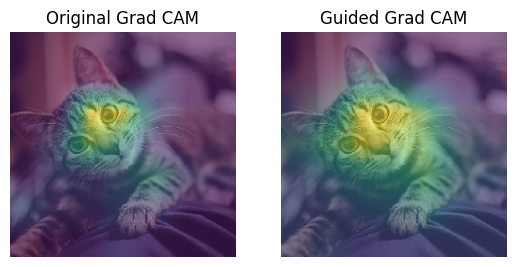

In [119]:
plt.subplot(1,2,1)
plt.imshow(image)
plt.imshow(gradcam, alpha=0.5)
plt.title('Original Grad CAM')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(image)
plt.imshow(guided_gradcam, alpha=0.5)
plt.title('Guided Grad CAM')
plt.axis('off')
plt.show()

Guided Grad-CAM (high resolution maps)

In [120]:
@tf.custom_gradient
def guided_relu(x):
    def grad(dy):
        return tf.cast(dy > 0, "float32") * tf.cast(x > 0, "float32") * dy

    return tf.nn.relu(x), grad

In [121]:
class GuidedBackprop:
    def __init__(self, model, layer_name: str):
        self.model = model
        self.layer_name = layer_name
        self.gb_model = self.build_guided_model()

    def build_guided_model(self):
        gb_model = tf.keras.Model(
            self.model.inputs, self.model.get_layer(self.layer_name).output
        )
        layers = [
            layer for layer in gb_model.layers[1:] if hasattr(layer, "activation")
        ]
        for layer in layers:
            if layer.activation == tf.keras.activations.relu:
                layer.activation = guided_relu
        return gb_model

    def guided_backprop(self, image: np.ndarray):
        with tf.GradientTape() as tape:
            inputs = tf.cast(image, tf.float32)
            tape.watch(inputs)
            outputs = self.gb_model(inputs)
        grads = tape.gradient(outputs, inputs)[0]
        return grads

In [122]:
gb = GuidedBackprop(model, "conv5_block3_out")

In [123]:
saliency_map = gb.guided_backprop(image[np.newaxis, ...]).numpy()
saliency_map = saliency_map * np.repeat(guided_gradcam[..., np.newaxis], 3, axis=2)

In [124]:
# normalize the feature map
saliency_map -= saliency_map.mean()
saliency_map /= saliency_map.std() + tf.keras.backend.epsilon()
saliency_map *= 0.25
saliency_map += 0.5
# scale the map values between (0,1)
saliency_map = np.clip(saliency_map, 0, 1) 
saliency_map *= (2 ** 8) - 1
saliency_map = saliency_map.astype(np.uint8)

(-0.5, 223.5, 223.5, -0.5)

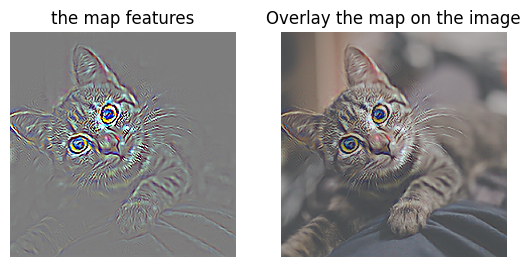

In [131]:
plt.subplot(1,2,1)
plt.imshow(saliency_map)
plt.title('the map features')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(image)
plt.imshow(saliency_map, alpha=0.5)
plt.title('Overlay the map on the image')
plt.axis('off')